# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE

In [2]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


In [3]:
# Dropping useless columns
churn = churn.drop(columns = ['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH', 'CUST_ID'])
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE
INDEX,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW


Dropped the reconnected column as it would just tell us who did not churn as they reconnected. Also dropped Customer ID as it would be useless as a predictor.

In [4]:
churn.shape

(46206, 17)

In [5]:
churn_count = churn['CHURN_IND'].value_counts()
churn_count

0    28416
1    17790
Name: CHURN_IND, dtype: int64

<AxesSubplot:>

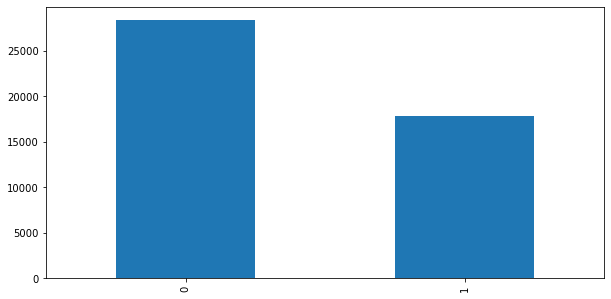

In [6]:
churn_count.plot.bar(figsize = (10, 5))

# Interpretation
There are 46206 customers in this dataset and out 28416 did not churn whereas 17790 did churn.

In [7]:
churn_handset= churn.groupby(['HANDSET_USED_BRAND', 'CHURN_IND']).size()

<AxesSubplot:xlabel='HANDSET_USED_BRAND,CHURN_IND'>

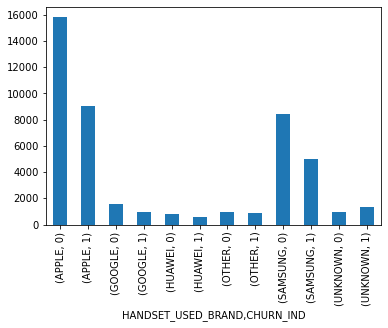

In [8]:
churn_handset.plot.bar()

# Interpretation
There doesnt seem to be a correlation between churn and handset the consumer uses.

In [9]:
churn_state= churn.groupby(['STATE', 'CHURN_IND']).size()

<AxesSubplot:xlabel='STATE,CHURN_IND'>

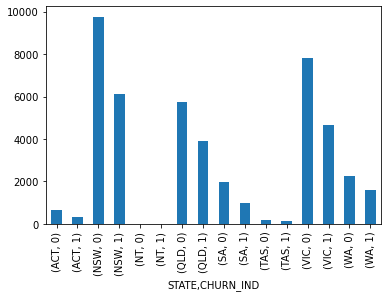

In [10]:
churn_state.plot.bar()

# Interpretation
There doesnt seem to be a correlation between churn and state the consumer lives.

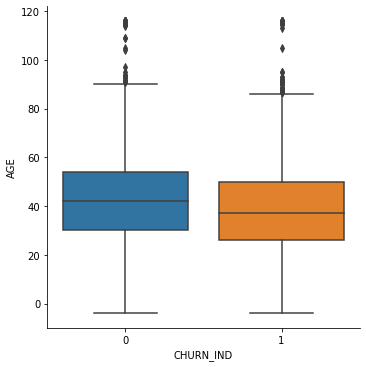

In [11]:
sns.catplot(x="CHURN_IND", y="AGE", data=churn, kind = 'box')

In [12]:
churn_acct_count = churn.groupby(['ACCT_CNT_SERVICES', 'CHURN_IND']).size()

<AxesSubplot:xlabel='ACCT_CNT_SERVICES,CHURN_IND'>

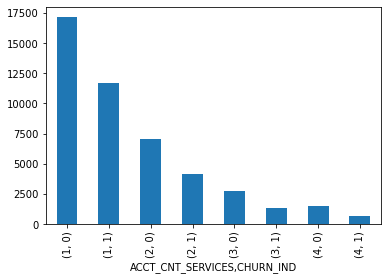

In [13]:
churn_acct_count.plot.bar()

# Interpretation
There doesnt seem to be a correlation between churn and the amount of account the consumer has.

In [14]:
churn_CFU = churn.groupby(['CFU', 'CHURN_IND']).size()

<AxesSubplot:xlabel='CFU,CHURN_IND'>

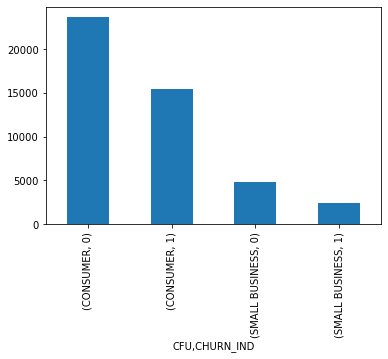

In [15]:
churn_CFU.plot.bar()

# Interpretation
There doesnt seem to be a correlation between churn and the type of consumer the customer is such as small business or indivudal.

In [16]:
churn_metro = churn.groupby(['COUNTRY_METRO_REGION', 'CHURN_IND']).size()

<AxesSubplot:xlabel='COUNTRY_METRO_REGION,CHURN_IND'>

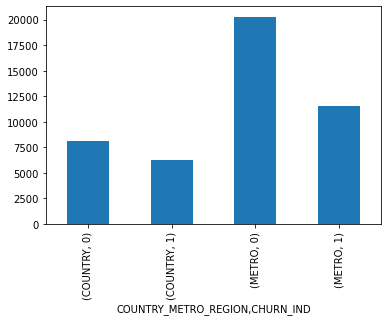

In [17]:
churn_metro.plot.bar()

# Interpretation
It looks like the country consumers churns more at a higher proportion than metro consumers.

In [18]:
churn_contract = churn.groupby(['CONTRACT_STATUS', 'CHURN_IND']).size()

<AxesSubplot:xlabel='CONTRACT_STATUS,CHURN_IND'>

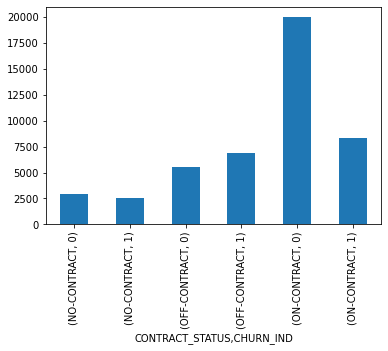

In [19]:
churn_contract.plot.bar()

# Interpretation
Off contract and no contract has a higher churn rate than consumers on contract.

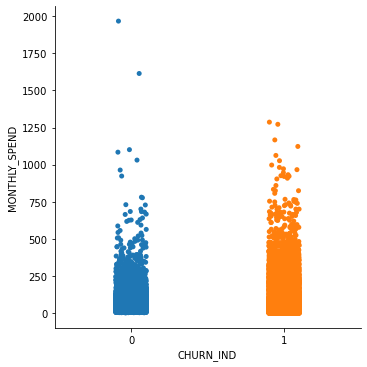

In [20]:
sns.catplot(x="CHURN_IND", y="MONTHLY_SPEND", data=churn)

# Interpretation
The chart illustrates that there are more consumers who churn when they spend more per month

In [21]:
churn_BYO = churn.groupby(['BYO_PLAN_STATUS', 'CHURN_IND']).size()

<AxesSubplot:xlabel='BYO_PLAN_STATUS,CHURN_IND'>

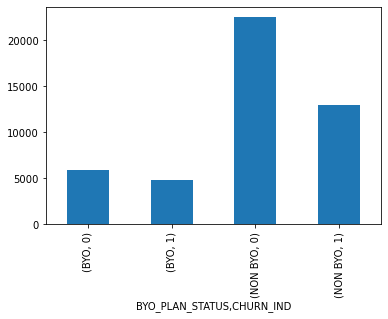

In [22]:
churn_BYO.plot.bar()

# Interpretation
Consumers whom were on a BYO plan seems to be more likely to churn than non-BYO consumers.

In [23]:
#Finding all null values
churn.isna().sum()

ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             76
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [24]:
#Dropping null values
churn = churn.dropna(axis=0)

Dropping null values as they cannot be included in the logistic regression

In [25]:
#Encode CFU values into numerical values from string 
le = LabelEncoder()
le.fit(list(churn['CFU'].values))

LabelEncoder()

In [26]:
#Inputting the values into a new column called CFU_no
churn['CFU_no'] = le.transform(list(churn['CFU']))

<ipython-input-26-557c11922439>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['CFU_no'] = le.transform(list(churn['CFU']))


In [27]:
#Encode BYO_PLAN_STATUS values into numerical values from string 
le = LabelEncoder()
le.fit(list(churn['BYO_PLAN_STATUS'].values))

LabelEncoder()

In [28]:
#Inputting the values into a new column called BYO_PLAN_STATUS_no
churn['BYO_PLAN_STATUS_no'] = le.transform(list(churn['BYO_PLAN_STATUS']))

<ipython-input-28-c6bc5e554c62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['BYO_PLAN_STATUS_no'] = le.transform(list(churn['BYO_PLAN_STATUS']))


In [29]:
#Encode CONTRACT_STATUS values into numerical values from string 
le = LabelEncoder()
le.fit(list(churn['CONTRACT_STATUS'].values))

LabelEncoder()

In [30]:
#Inputting the values into a new column called CONTRACT_STATUS
churn['CONTRACT_STATUS_no'] = le.transform(list(churn['CONTRACT_STATUS']))

<ipython-input-30-5a13e6bb4ce4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['CONTRACT_STATUS_no'] = le.transform(list(churn['CONTRACT_STATUS']))


In [31]:
#Encode HANDSET_USED_BRAND_no values into numerical values from string 
le = LabelEncoder()
le.fit(list(churn['HANDSET_USED_BRAND'].values))

LabelEncoder()

In [32]:
#Inputting the values into a new column called HANDSET_USED_BRAND_no
churn['HANDSET_USED_BRAND_no'] = le.transform(list(churn['HANDSET_USED_BRAND']))

<ipython-input-32-748a38bd8701>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['HANDSET_USED_BRAND_no'] = le.transform(list(churn['HANDSET_USED_BRAND']))


In [33]:
#Encode COUNTRY_METRO_REGION_no values into numerical values from string 
le = LabelEncoder()
le.fit(list(churn['COUNTRY_METRO_REGION'].values))

LabelEncoder()

In [34]:
#Inputting the values into a new column called COUNTRY_METRO_REGION
churn['COUNTRY_METRO_REGION_no'] = le.transform(list(churn['COUNTRY_METRO_REGION']))

<ipython-input-34-dad1bd83252c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['COUNTRY_METRO_REGION_no'] = le.transform(list(churn['COUNTRY_METRO_REGION']))


In [35]:
#Encode STATE_no values into numerical values from string 
le = LabelEncoder()
le.fit(list(churn['STATE'].values))

LabelEncoder()

In [36]:
#Inputting the values into a new column called STATE
churn['STATE_no'] = le.transform(list(churn['STATE']))

<ipython-input-36-2be121012ed5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['STATE_no'] = le.transform(list(churn['STATE']))


Converted all the string values too categorical as logistic regression cant pick up string values

In [37]:
churn.head()

,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,...,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,CFU_no,BYO_PLAN_STATUS_no,CONTRACT_STATUS_no,HANDSET_USED_BRAND_no,COUNTRY_METRO_REGION_no,STATE_no
INDEX,,,,,,,,,,,,,,,,,,,,,
1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,24,...,1,61.40,COUNTRY,WA,0,1,1,4,0,7
2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,24,...,1,54.54,METRO,NSW,0,1,1,0,1,1
3,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,12,...,1,2.50,COUNTRY,WA,0,0,1,0,0,7
4,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,24,...,1,6.48,COUNTRY,VIC,0,1,1,0,0,6
5,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,24,...,1,100.22,METRO,NSW,0,1,1,0,1,1


In [38]:
# Split your data into training(80%) and testing data (20%) and the random state of 142 to keep it consistent
train, test = train_test_split(churn, test_size=0.2,random_state=142)
print(train.shape)
print(test.shape)

(36903, 23)
(9226, 23)


In [39]:
#Building the logisitc regression model
X_train = train.drop(['CFU','BYO_PLAN_STATUS', 'COUNTRY_METRO_REGION' , 'HANDSET_USED_BRAND', 'STATE' ,'CONTRACT_STATUS' ,'CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CFU', 'BYO_PLAN_STATUS' , 'COUNTRY_METRO_REGION' ,'HANDSET_USED_BRAND' , 'STATE' ,'CONTRACT_STATUS','CHURN_IND'], axis=1)
y_test = test['CHURN_IND']
lr = LogisticRegression(max_iter=700)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=700)

In [40]:
# Do predictions on test and train set
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [41]:
print("Train accuracy: ")
print(accuracy_score(y_train, train_preds))
print("Test accuracy: ")
print(accuracy_score(y_test, test_preds))

Train accuracy: 
0.7260114353846571
Test accuracy: 
0.7174290049859093


In [42]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, train_preds))
print("Test confusion matrix:")
print(confusion_matrix(y_test, test_preds))

Train confusion matrix:
[[18924  3787]
 [ 6324  7868]]
Test confusion matrix:
[[4680  975]
 [1632 1939]]


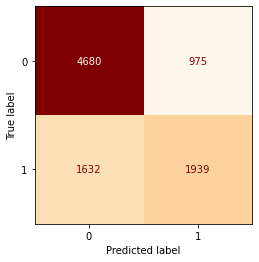

In [43]:
plot_confusion_matrix(lr,X_test, y_test,cmap="OrRd", colorbar=False)

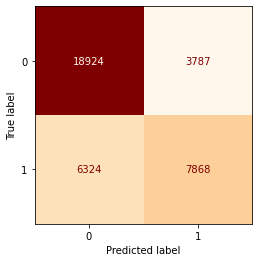

In [44]:
plot_confusion_matrix(lr,X_train, y_train,cmap="OrRd", colorbar=False)

# Interpretation
The accuracy for both train and test dataset similar at 0.726 accracy on train dataset, test accuracy is on 0.717429 which means there doesnt seem to be any indications of the model overfitting. The confusion matrix illustrates the false positives and the false negatives of the prediction. There seems to be a higher amount of false negatives than false postives. 

# Feature selection

In [45]:
#Fitting every feature in the logistic regression and mesuring each accuracy
train_accuracies= []
test_accuracies= []
for i in range(X_train.shape[1]):
    lr = LogisticRegression(max_iter=700)
    rfe = RFE(estimator = lr, n_features_to_select=i+1, step = 1)
    rfe.fit(X_train, y_train)
    
    train_rfe_preds = rfe.predict(X_train)
    test_rfe_preds = rfe.predict(X_test)

    train_accuracies.append(accuracy_score(y_train, train_rfe_preds))
    test_accuracies.append(accuracy_score(y_test, test_rfe_preds))


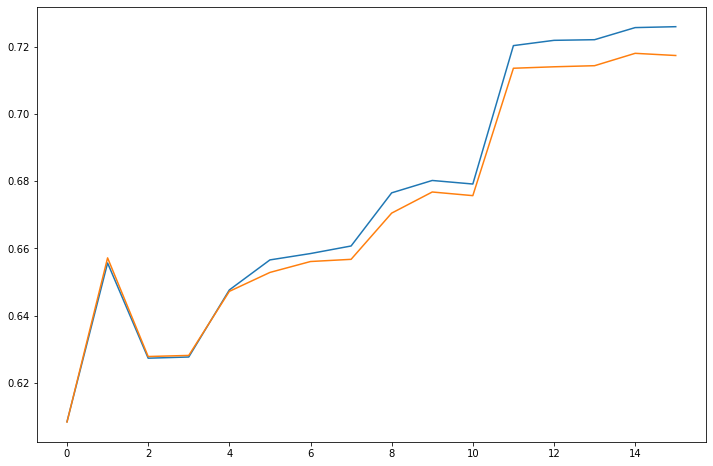

In [46]:
#Fitting the accuracy scores on a line graph
plt.figure(figsize=(12,8))
plt.plot(range(X_train.shape[1]), train_accuracies)
plt.plot(range(X_train.shape[1]), test_accuracies)

# Interpretation
This graph shows which RFE gives the best accuracy score. The more features selected the better the model becomes. However too many features may lead to the model overfitting. Therefore 11 may be the best fit as there was a 4% increase in Predictability.

In [47]:
#Fitting best 12 features in model
lr = LogisticRegression(max_iter=700)
rfe = RFE(estimator = lr, n_features_to_select=12, step = 1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(max_iter=700), n_features_to_select=12)

In [48]:
#Identifying  which columns were selected for the model 
X_train.columns[rfe.support_]

Index(['ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'AGE',
       'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION',
       'PREV_CONTRACT_DURATION', 'MONTHLY_SPEND', 'CFU_no',
       'BYO_PLAN_STATUS_no', 'CONTRACT_STATUS_no', 'HANDSET_USED_BRAND_no',
       'COUNTRY_METRO_REGION_no'],
      dtype='object')

In [49]:
#Ranking which column supports the model best
rfe.ranking_

array([1, 1, 1, 4, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5])

In [50]:
#Doing predictions on test and train set
train_rfe_preds = rfe.predict(X_train)
test_rfe_preds = rfe.predict(X_test)

print("Train accuracy: ")
print(accuracy_score(y_train, train_rfe_preds))

print("Test accuracy: ")
print(accuracy_score(y_test, test_rfe_preds))

Train accuracy: 
0.7203750372598434
Test accuracy: 
0.7136353782787773


# Interpretation
The SERVICE_TENURE, PLAN_ACCESS_FEE, PLAN_TENURE, STATE_no, columns were not useful in predicting the model therefore they were removed. The accuracy of the train and test are also similar on 0.720375 and 0.7136 respectively.

# Conclusion
The accuracy scores for both train and test set is at around 70% meaning the model can somewhat predict whether the consumer would churn. Both the train and test set have similar accuracy scores meaning the model is not overfitting. The confusion matrix illustrates that the model can more likely predict a true negative result than a true positive. The model also predicts a false negative just as well the model predicts a true positive. The RFE gives the best features that should be selected as they are ACCOUNT_TENURE, AGE, MONTHS_OF_CONTRACT_REMAINING, LAST_FX_CONTRACT_DURATION, PREV_CONTRACT_DURATION, MONTHLY_SPEND, CFU_no, BYO_PLAN_STATUS_no, CONTRACT_STATUS_no, HANDSET_USED_BRAND_no, COUNTRY_METRO_REGION_no. The rest shouldn’t be used in the logistic regression model as the more features there are the more likely the model will overfit.